# Visual Introduction to Classification and Logistic Regression
Taken from: https://dfrieds.com/machine-learning/visual-introduction-classification-logistic-regression-python#fit-logistic-regression-model-on-credit-card-data

### Import modules

In [346]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.ticker as tick
import matplotlib.patches as patches
import matplotlib.pyplot as plt

### Visualization Setup

In [347]:
sns.set_context("talk")
sns.set_style("whitegrid", {'grid.color': '.92'})

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)

    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format


## Visual Derivation of Logistic Regression Equation
We'll utilize a single feature, yearly income, and two class labels of approved and denied.

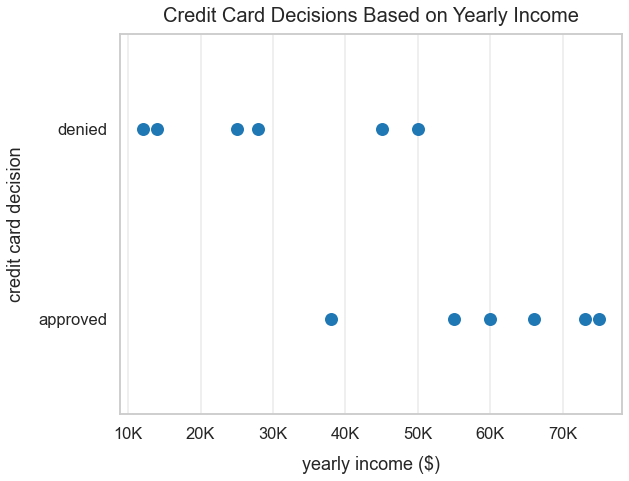

In [348]:
yearly_incomes_us_dollars = [12000, 14000, 25000, 28000, 38000, 45000, 50000, 55000, 60000, 66000, 73000, 75000]
credit_card_decisions = ["denied"]*4 + ["approved"] + ["denied"]*2 + ["approved"]*5

application_data = {'yearly_income': yearly_incomes_us_dollars,
        'credit_card_decision': credit_card_decisions
        }
df_credit_card_applications = pd.DataFrame(application_data)

plt.figure(figsize=(9, 7))
sns.stripplot(data=df_credit_card_applications, x="yearly_income", y="credit_card_decision", jitter=False, size=13)
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Let's create a divide where people that earn over $51,000 per year are likely to be approved.

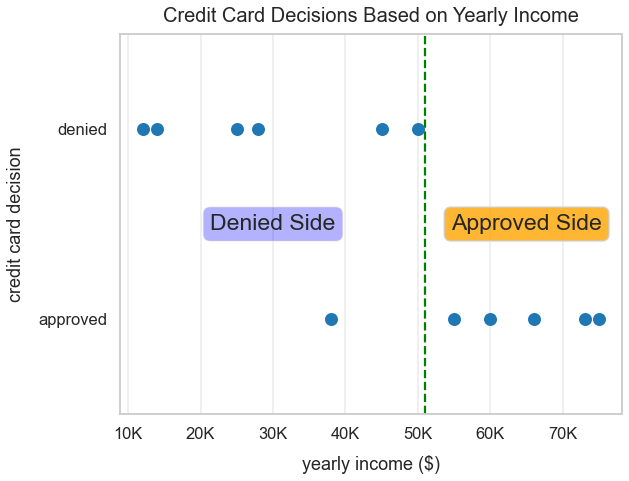

In [349]:
plt.figure(figsize=(9, 7))
ax = sns.stripplot(data=df_credit_card_applications, x="yearly_income", y="credit_card_decision", jitter=False, size=13)
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
plt.axvline(x=51000, linestyle="--", color='green')
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.8)
ax.text(65000, 0.5, "Approved Side", ha="center", va="center", size=23, bbox=bbox_props_approved)
bbox_props_denied = dict(boxstyle="round", fc="blue", ec="0.8", alpha=0.3)
ax.text(30000, 0.5, "Denied Side", ha="center", va="center", size=23, bbox=bbox_props_denied)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

### 2 Features
Let's incorporate credit score data to help build out best fit equation.

In [350]:
credit_scores = [580, 600, 620, 640, 680, 670, 650, 700, 690, 710, 680, 715]

application_data["credit_score"] = credit_scores
df_credit_card_applications = pd.DataFrame(application_data)

df_credit_card_applications

,yearly_income,credit_card_decision,credit_score
0,12000,denied,580
1,14000,denied,600
2,25000,denied,620
3,28000,denied,640
4,38000,approved,680
5,45000,denied,670
6,50000,denied,650
7,55000,approved,700
8,60000,approved,690
9,66000,approved,710


Let's visualize our two features and two class labels.

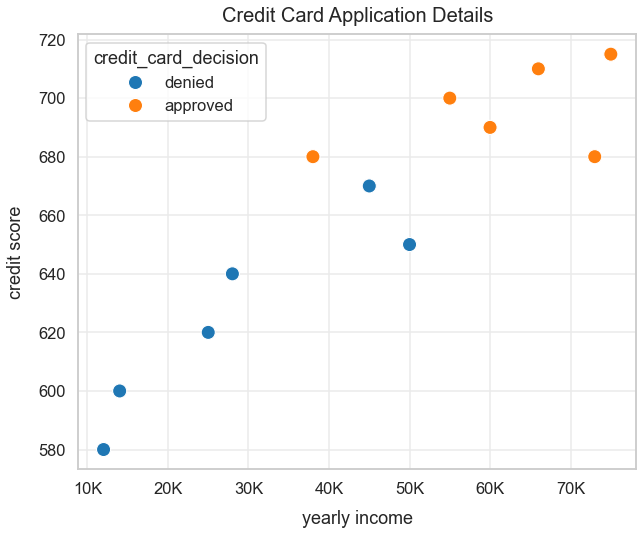

In [351]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='yearly_income', y='credit_score', hue='credit_card_decision', data=df_credit_card_applications, s=200)
plt.title("Credit Card Application Details", y=1.015, fontsize=20)
plt.xlabel("yearly income", labelpad=13)
plt.ylabel("credit score", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

### Visually Predict Which Class a New Observation Belongs To
Let's pick a random point on the chart, our intuition tells us it would be denied.

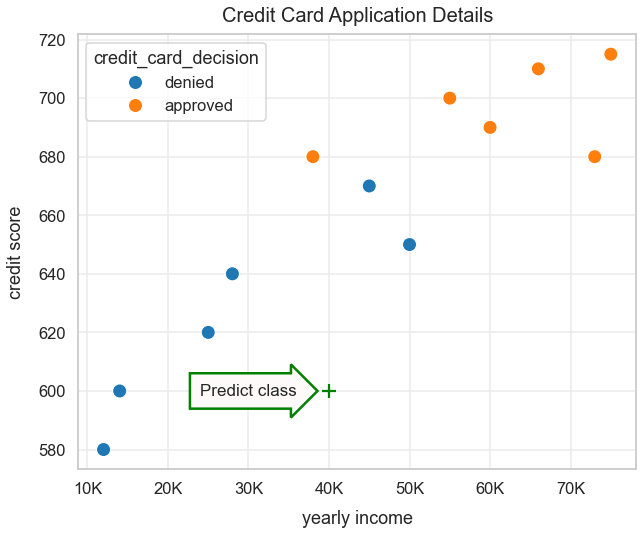

In [352]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='yearly_income', y='credit_score', hue='credit_card_decision', data=df_credit_card_applications, s=200)
plt.scatter([40000], [600], c='green', s=200, marker='+')
bbox_props = dict(boxstyle="rarrow, pad=0.6", fc="snow", ec="g", lw=2.5)
t = ax.text(30000, 600, "Predict class", ha="center", va="center", size=17, bbox=bbox_props)
plt.title("Credit Card Application Details", y=1.015, fontsize=20)
plt.xlabel("yearly income", labelpad=13)
plt.ylabel("credit score", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

With this in mind, it appears we can create a dividing line that seperates almost all the data.

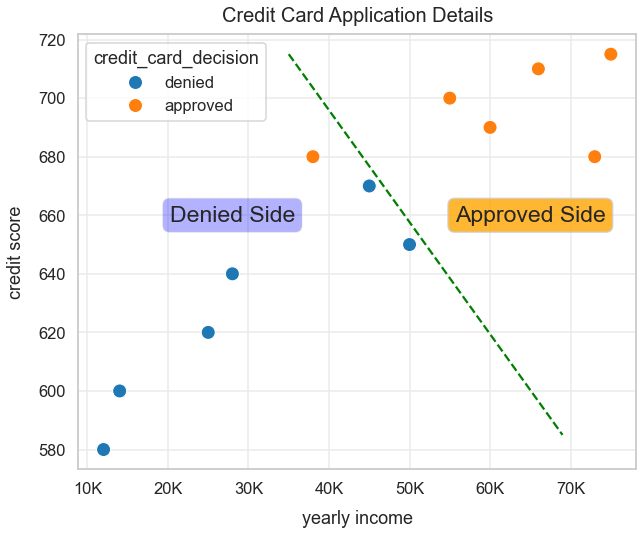

In [353]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x='yearly_income', y='credit_score', hue='credit_card_decision', data=df_credit_card_applications, s=200)
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.8)
ax.text(65000, 660, "Approved Side", ha="center", va="center", size=23, bbox=bbox_props_approved)
bbox_props_denied = dict(boxstyle="round", fc="blue", ec="0.8", alpha=0.3)
ax.text(28000, 660, "Denied Side", ha="center", va="center", size=23, bbox=bbox_props_denied);
plt.plot([35000, 69000], [715, 585], linestyle="--", color='green')
plt.title("Credit Card Application Details", y=1.015, fontsize=20)
plt.xlabel("yearly income", labelpad=13)
plt.ylabel("credit score", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

### Let's Try Linear Regression for Classification
Create a `decision label` that marks 1 if the a decision is approved. Let's visualize this in a couple ways.

In [354]:
df_credit_card_applications['decision_label'] = np.where(df_credit_card_applications['credit_card_decision']=="approved", 1, 0)

df_credit_card_applications[['credit_card_decision', 'decision_label']].sample(5)

,credit_card_decision,decision_label
0,denied,0
3,denied,0
7,approved,1
9,approved,1
11,approved,1


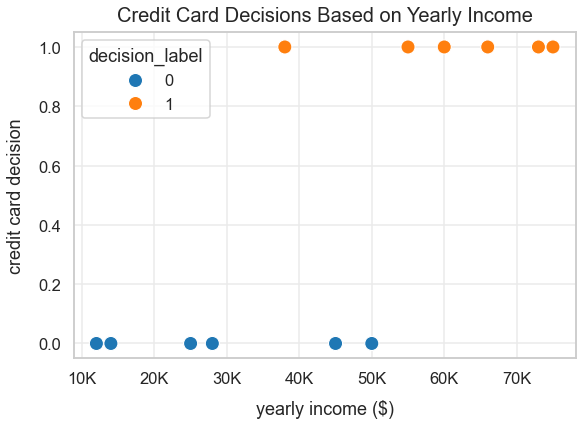

In [355]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Now, we will fit a linear regression model to out entire dataset using sklearn objects.

In [356]:
linear_regression = LinearRegression()

x_values = df_credit_card_applications['yearly_income'].values.reshape(-1,1)
x_values

array([[12000],
       [14000],
       [25000],
       [28000],
       [38000],
       [45000],
       [50000],
       [55000],
       [60000],
       [66000],
       [73000],
       [75000]], dtype=int64)

In [357]:
y_values = df_credit_card_applications['decision_label'].values
y_values

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1])

Fit our data and calculate a coefficient and an intercept

In [358]:
lr = linear_regression.fit(x_values, y_values)
lr.coef_

array([1.83358404e-05])

In [359]:
lr.intercept_

-0.3266408043702007

Our linear regression line of best fit can be modeled by the quation `target = lr.intercept_ + yearly_income * lr.coef_1`.
Let's plot this.

In [360]:
min_income = df_credit_card_applications['yearly_income'].min()
max_income = df_credit_card_applications['yearly_income'].max()

print("min_income: {0}".format(min_income))
print("max_income: {0}".format(max_income))

min_income: 12000
max_income: 75000


We can use the `predict` method to predict decision values

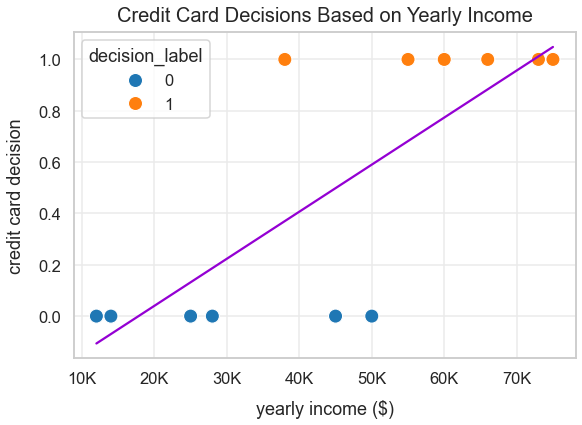

In [361]:
lr.predict(x_values.reshape(-1, 1))

plt.figure(figsize=(9, 6))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.plot([min_income, max_income], [lr.predict(min_income.reshape(-1, 1)), lr.predict(max_income.reshape(-1, 1))], c='darkviolet')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Calculate the R^2 value, `0.58` is reasonalbe but fails to capture a lot of variance.

In [362]:
r_squared = lr.score(x_values, y_values)
r_squared

0.5898028659646901

Let's create a **decision threshold** below. This represents the result of a quantitative test to a simple binary decision.

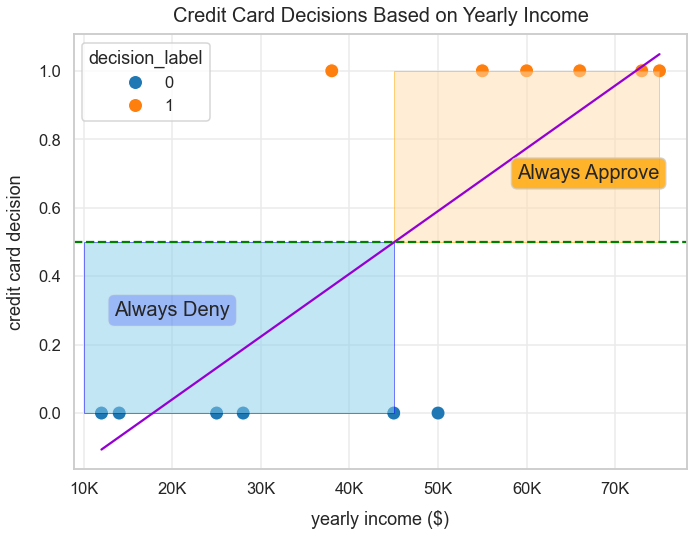

In [363]:
plt.figure(figsize=(11, 8))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.plot([min_income, max_income], [lr.predict(min_income.reshape(-1, 1)), lr.predict(max_income.reshape(-1, 1))], c='darkviolet')
plt.axhline(y=0.5, linestyle="--", color='green')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
orange_rect = patches.Rectangle((45000,0.5), 30000, 0.5, linewidth=1, edgecolor='orange', facecolor='navajowhite', alpha=0.5)
ax.add_patch(orange_rect)
blue_rect = patches.Rectangle((10000, 0), 35000, 0.5, linewidth=1, edgecolor='blue', facecolor='skyblue', alpha=0.5)
ax.add_patch(blue_rect)
bbox_props_approved = dict(boxstyle="round", fc="orange", ec="0.8", alpha=0.8)
ax.text(67000, 0.7, "Always Approve", ha="center", va="center", size=20, bbox=bbox_props_approved)
bbox_props_denied = dict(boxstyle="round", fc="blue", ec="0.8", alpha=0.2)
ax.text(20000, 0.3, "Always Deny", ha="center", va="center", size=20, bbox=bbox_props_denied)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Let's show another reason that linear regression isn't the best fit model ofr this data. We'll add a high income individual to the dataset and define `max_income_outlier`.

In [364]:
wealthy_person = {'yearly_income': [250000],
        'credit_card_decision': ["approved"],
                  'credit_score': [715],
                  'decision_label': [1]
        }
df_wealthy = pd.DataFrame(wealthy_person)

df_cc_applications_with_outlier = pd.concat([df_credit_card_applications, df_wealthy])

linear_regression2 = LinearRegression()
x_values2 = df_cc_applications_with_outlier['yearly_income'].values.reshape(-1,1)
y_values2 = df_cc_applications_with_outlier['decision_label'].values
lr2 = linear_regression2.fit(x_values2, y_values2)

max_income_outlier = df_cc_applications_with_outlier['yearly_income'].max()

It's clear this line doesn't capture the variance in out data well.

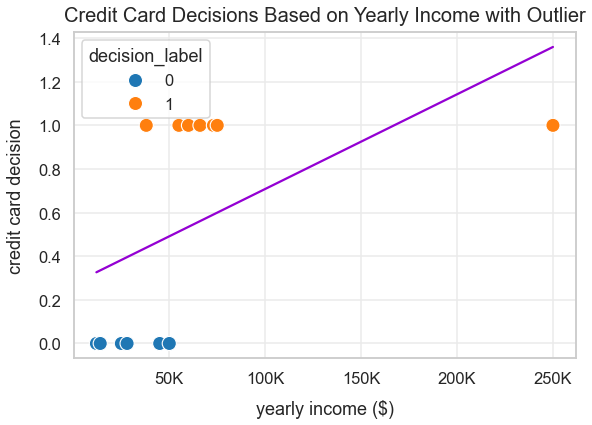

In [365]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_cc_applications_with_outlier, s=200)
plt.plot([min_income, max_income_outlier], [lr2.predict(min_income.reshape(-1, 1)), lr2.predict(max_income_outlier.reshape(-1, 1))], c='darkviolet')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income with Outlier", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

Let's loook at our data without the outlier, but keeping the same scale. This doesn't make sense! We have decisions that are above 1 when it's supposed to be binary!

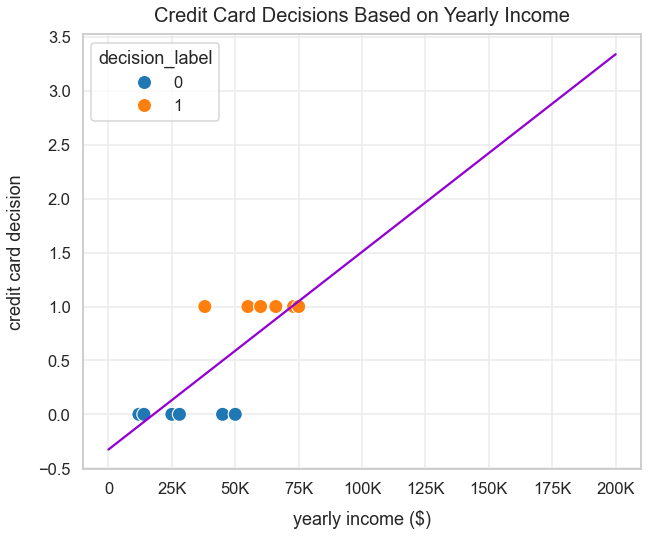

In [366]:
zero_income = np.array([0])
super_high_income = np.array([200000])
plt.figure(figsize=(10, 8))
sns.scatterplot(x="yearly_income", y="decision_label", hue="decision_label", data=df_credit_card_applications, s=200)
plt.plot([zero_income, super_high_income], [lr.predict(zero_income.reshape(-1, 1)), lr.predict(super_high_income.reshape(-1, 1))], c='darkviolet')
plt.xlabel("yearly income ($)", labelpad=13)
plt.ylabel("credit card decision", labelpad=13)
plt.title("Credit Card Decisions Based on Yearly Income", y=1.015, fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

## Logistic Regression to the Rescue!
We need a better line of fit to classify our data. Let's use the **Sigmoid Function** to represent an s-shaped curve. Let's also preview some x values.

In [367]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x_values_for_sigmoid = np.linspace(-10, 10, 120)
x_values_for_sigmoid[0:5]

array([-10.        ,  -9.83193277,  -9.66386555,  -9.49579832,
        -9.32773109])

Using this function, as seen below, we always approach 0 or 1 but never exceed them. This is exactly what we need for our model.

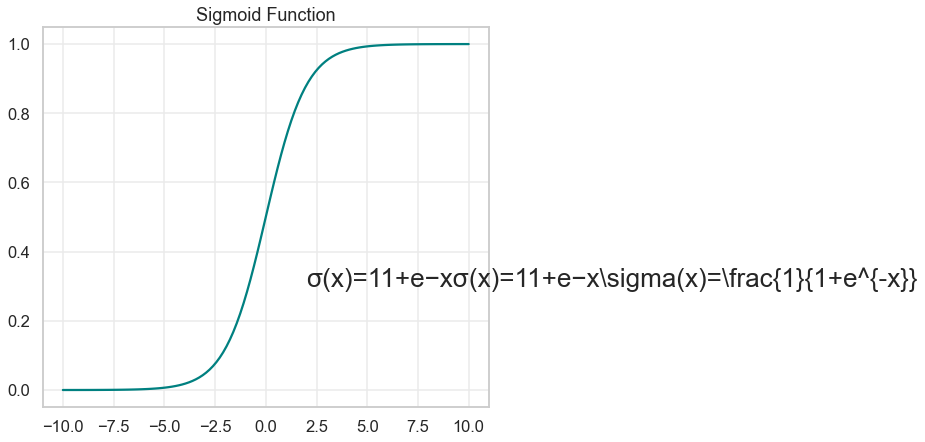

In [368]:
plt.figure(figsize=(8, 7))
plt.plot(x_values_for_sigmoid, sigmoid(x_values_for_sigmoid), c='teal')
plt.title('Sigmoid Function')
plt.grid(True)
plt.text(2, 0.3, r'σ(x)=11+e−xσ(x)=11+e−x\sigma(x)=\frac{1}{1+e^{-x}}', fontsize=26)
plt.show()

### Logistic Function
We expect a normal distribution with income levels, let's generate and visualize more data.

C:\Users\cjsta\AppData\Local\Temp\ipykernel_18852\2783129644.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yearly_incomes_us_dollars)


<AxesSubplot:ylabel='Density'>

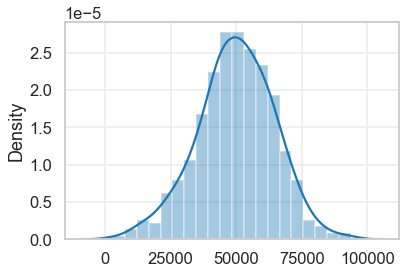

In [369]:
yearly_incomes_us_dollars = np.random.normal(loc=50000, scale=15000, size=500)
sns.distplot(yearly_incomes_us_dollars)

Let's sort from least to greatest and then use `pandas` cut method to cut the data into five bins. 

In [370]:
yearly_incomes_us_dollars = sorted(yearly_incomes_us_dollars)

credit_card_decisions = [0]*180 + [1]*4 + [0]*16 + [1]*5 + [0]*10 + [1]*(500-215)

application_data = {'yearly_income': yearly_incomes_us_dollars,
        'credit_card_decision': credit_card_decisions
        }
df_credit_card_applications2 = pd.DataFrame(application_data)

income_bin_labels = pd.cut(df_credit_card_applications2['yearly_income'], bins=5, labels=["very low", "low", "medium", "high", "very high"])

df_credit_card_applications2['income_bucket'] = income_bin_labels

df_credit_card_applications2['income_bucket'].value_counts()

medium       235
high         142
low           94
very low      15
very high     14
Name: income_bucket, dtype: int64

Let's see what these bins look like with our decisions.

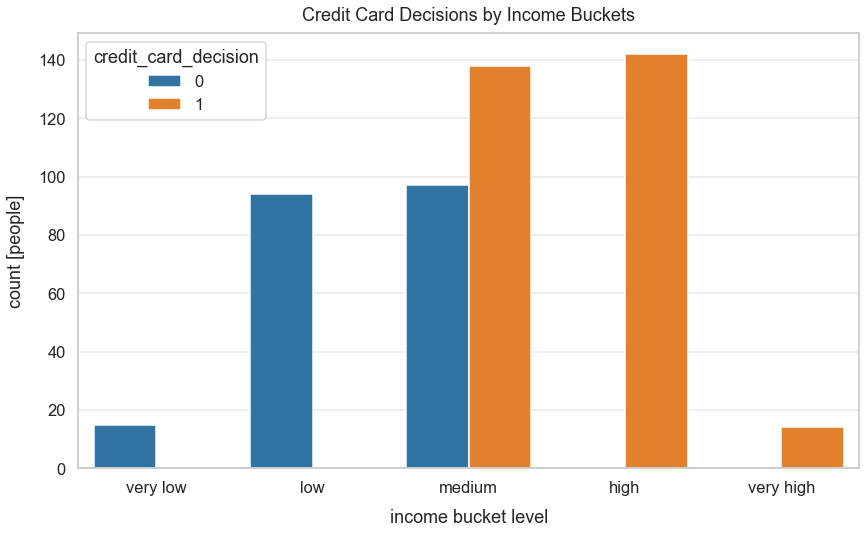

In [371]:
plt.figure(figsize=(14, 8))
sns.countplot(x='income_bucket', hue='credit_card_decision', data=df_credit_card_applications2)
plt.title("Credit Card Decisions by Income Buckets", y=1.015)
plt.ylabel("count [people]", labelpad=13)
plt.xlabel("income bucket level", labelpad=13);

<Figure size 1008x576 with 0 Axes>

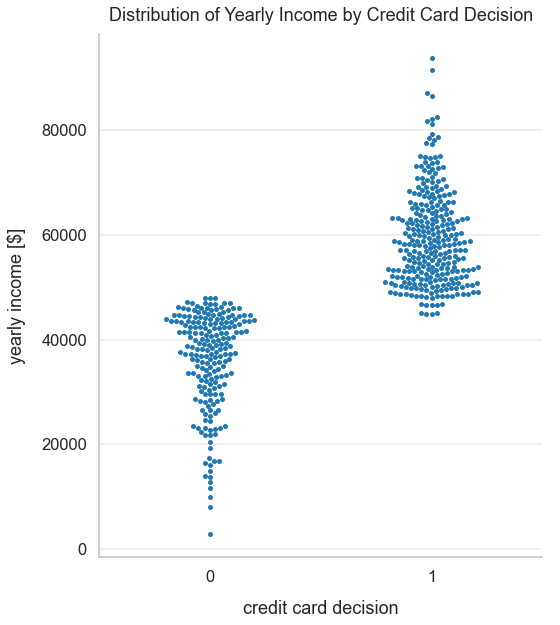

In [372]:
plt.figure(figsize=(14, 8))
sns.catplot(x="credit_card_decision", y="yearly_income", kind="swarm", data=df_credit_card_applications2, height=8.5, aspect=.9)
plt.xlabel("credit card decision", labelpad=15)
plt.ylabel("yearly income [$]", labelpad=15)
plt.title("Distribution of Yearly Income by Credit Card Decision", y=1.013);

Standarize our feature `yearly_income`. Logistic regressions by default use regularized valued. 

In [373]:
X = df_credit_card_applications2['yearly_income'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

Let's preview what this looks like.

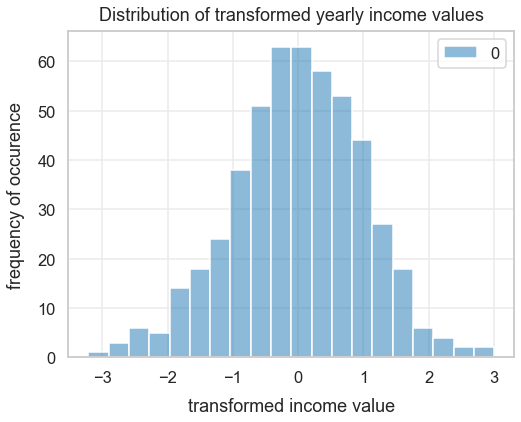

In [376]:
plt.figure(figsize=(8, 6))
sns.histplot(X_transformed)
plt.title("Distribution of transformed yearly income values", y=1.015)
plt.xlabel("transformed income value", labelpad=12)
plt.ylabel("frequency of occurence", labelpad=12);

In [ ]:
y = df_credit_card_applications2['credit_card_decision'].values
log_reg = LogisticRegression()